# 02_feature_engineering.ipynb

## Imports Lib


In [265]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import ta
import matplotlib.pyplot as plt
import seaborn as sns

# Load & clean raw data

In [266]:
df = pd.read_csv("../data/raw/sp500_raw.csv", index_col=0)
df.index = pd.to_datetime(df.index, errors="coerce").map(lambda x: x.tz_convert(None) if x.tzinfo else x)
df = df[df.index.notnull()]
df = df[df.index >= datetime(1990, 1, 1)].copy()

C:\Users\parks\AppData\Local\Temp\ipykernel_12104\459284702.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df.index = pd.to_datetime(df.index, errors="coerce").map(lambda x: x.tz_convert(None) if x.tzinfo else x)


# Create target column


In [267]:
df["Tomorrow"] = df["Close"].shift(-1)
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)

# Rolling averages and trends


In [268]:
horizons = [2, 5, 20, 60, 120, 250, 1000]
for h in horizons:
    df[f"Close_Ratio_{h}"] = df["Close"] / df["Close"].rolling(h).mean()
    df[f"Trend_{h}"] = df["Target"].shift(1).rolling(h).sum()

# Technical indicator features


In [269]:
df["RSI_14"] = ta.momentum.RSIIndicator(close=df["Close"], window=14).rsi()
macd = ta.trend.MACD(close=df["Close"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()
df["MACD_diff"] = df["MACD"] - df["MACD_Signal"]
df["EMA_5"] = ta.trend.EMAIndicator(close=df["Close"], window=5).ema_indicator()
df["EMA_20"] = ta.trend.EMAIndicator(close=df["Close"], window=20).ema_indicator()
bb = ta.volatility.BollingerBands(close=df["Close"], window=20, window_dev=2)
df["BB_High"] = bb.bollinger_hband()
df["BB_Low"] = bb.bollinger_lband()
df["Momentum_10"] = ta.momentum.ROCIndicator(close=df["Close"], window=10).roc()
df["ATR_14"] = ta.volatility.AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"], window=14).average_true_range()
df["OBV"] = ta.volume.OnBalanceVolumeIndicator(close=df["Close"], volume=df["Volume"]).on_balance_volume()

# Lag-based features


In [270]:
df["Lag_Close_1"] = df["Close"].shift(1)
df["Lag_Close_2"] = df["Close"].shift(2)
df["Lag_Volume_1"] = df["Volume"].shift(1)

# Strategy-driven features


In [271]:
# Crossover: EMA 5 > EMA 20
df["EMA_Cross"] = (df["EMA_5"] > df["EMA_20"]).astype(int)

# Price distance from EMA 20
df["Close_EMA20_Pct"] = (df["Close"] - df["EMA_20"]) / df["EMA_20"]

# Bollinger Band width & volatility %
df["Bollinger_Width"] = df["BB_High"] - df["BB_Low"]
df["Volatility_Pct"] = df["Bollinger_Width"] / df["Close"]

# Momentum acceleration
df["Momentum_Change"] = df["Momentum_10"].diff()

# Relative volume
df["Volume_Ratio_5"] = df["Volume"] / df["Volume"].rolling(5).mean()

# Volume Z-Score
df["Volume_ZScore"] = (df["Volume"] - df["Volume"].rolling(20).mean()) / df["Volume"].rolling(20).std()

# Price up streak (past 5 days)
df["Price_Up_Streak"] = df["Target"].rolling(5).sum()

# MACD crossover
df["MACD_Cross"] = (df["MACD"] > df["MACD_Signal"]).astype(int)

# Strong momentum
df["Momentum_StrongUp"] = (df["Momentum_10"] > 5).astype(int)
df["Momentum_StrongDown"] = (df["Momentum_10"] < -5).astype(int)


# Drop missing & export data


In [272]:
df.dropna(inplace=True)
print(df.isna().sum().sort_values(ascending=False).head(10))

Open             0
High             0
Low              0
Close            0
Volume           0
Tomorrow         0
Target           0
Close_Ratio_2    0
Trend_2          0
Close_Ratio_5    0
dtype: int64


# Compute correlation matrix for top 25 features most correlated with Target


In [273]:
cor_matrix = df.corr(numeric_only=True)
top_features = cor_matrix["Target"].abs().sort_values(ascending=False).head(25).index
top_corr = cor_matrix.loc[top_features, top_features]

# Plot heatmap


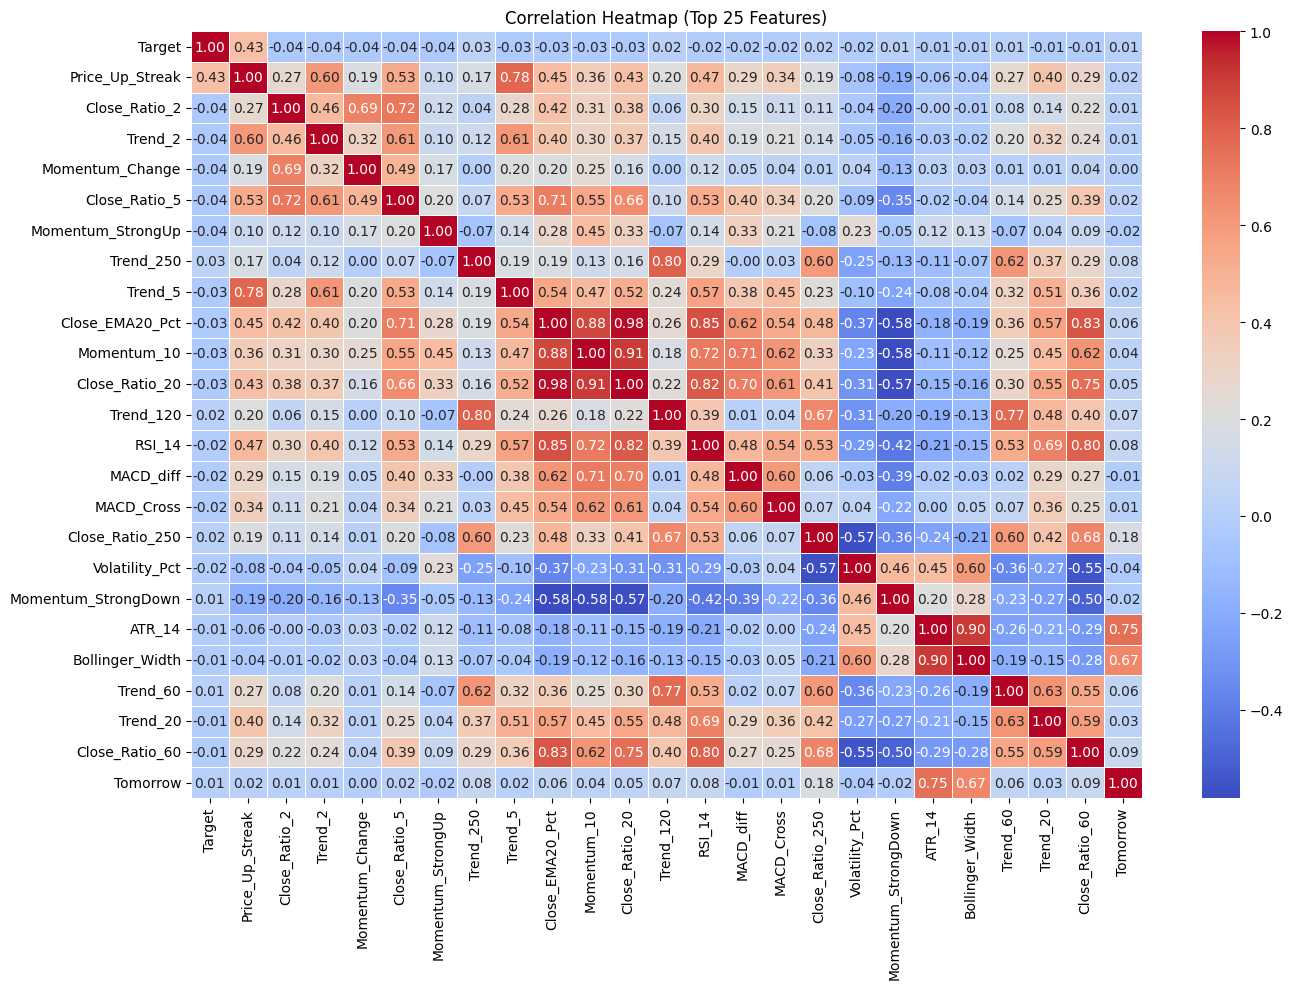

In [274]:
plt.figure(figsize=(14, 10))
sns.heatmap(top_corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Top 25 Features)")
plt.tight_layout()
plt.savefig("../reports/images/features/correlation_heatmap_top25.png")
plt.show()

# Save full version with all features


In [275]:
os.makedirs("../data/processed", exist_ok=True)
df.to_csv("../data/processed/sp500_cleaned.csv")

# Save cleaned version for model training (excluding future leakage)


In [276]:
features_for_modeling = [col for col in df.columns if col not in ["Tomorrow", "Target"]]
df_model = df[features_for_modeling + ["Target"]]
df_model.to_csv("../data/processed/sp500_cleaned_model_ready.csv")
print(f"Saved model-ready dataset: shape = {df_model.shape}")

Saved model-ready dataset: shape = (7872, 45)


# Correlation analysis


In [277]:
correlation = df.corr(numeric_only=True)["Target"].sort_values(ascending=False)
print("\nTop correlated features with Target:")
print(correlation.head(15))
print("\nLeast correlated features:")
print(correlation.tail(5))


Top correlated features with Target:
Target                 1.000000
Price_Up_Streak        0.434864
Trend_250              0.032107
Trend_120              0.020804
Close_Ratio_250        0.015748
Momentum_StrongDown    0.014411
Trend_60               0.012221
Tomorrow               0.008723
OBV                    0.005484
Volume                 0.005140
Lag_Volume_1           0.004229
Trend_1000             0.003882
Volume_Ratio_5         0.002957
MACD_Signal            0.002820
Volume_ZScore          0.002512
Name: Target, dtype: float64

Least correlated features:
Momentum_StrongUp   -0.036583
Close_Ratio_5       -0.036715
Momentum_Change     -0.037043
Trend_2             -0.037551
Close_Ratio_2       -0.043850
Name: Target, dtype: float64


# Visualizations

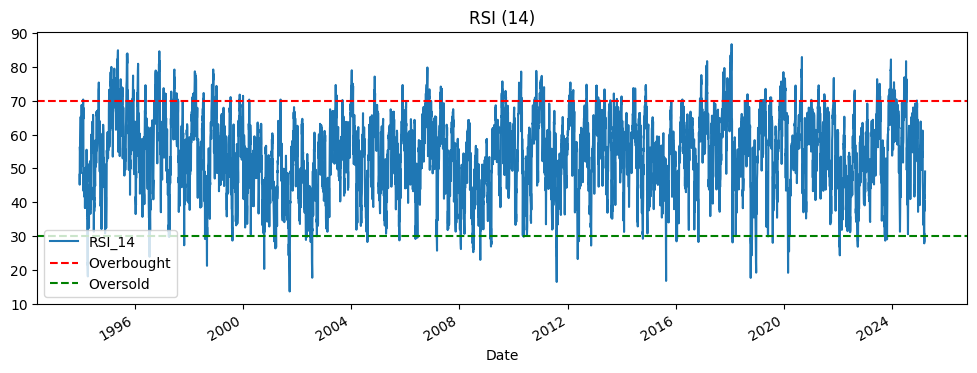

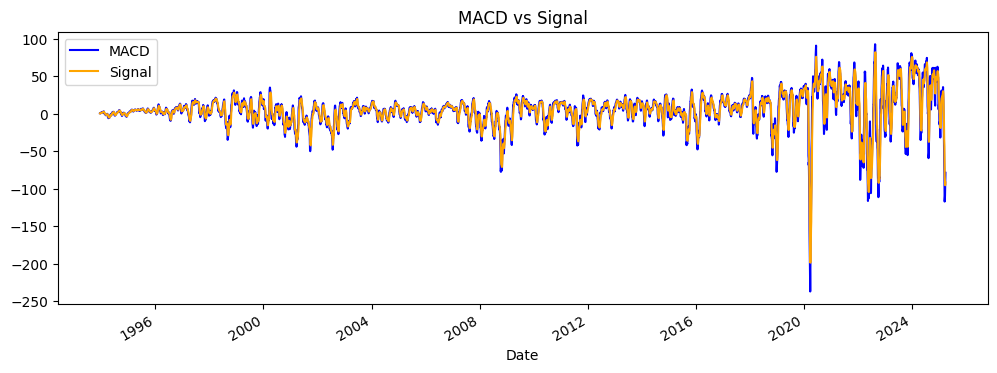

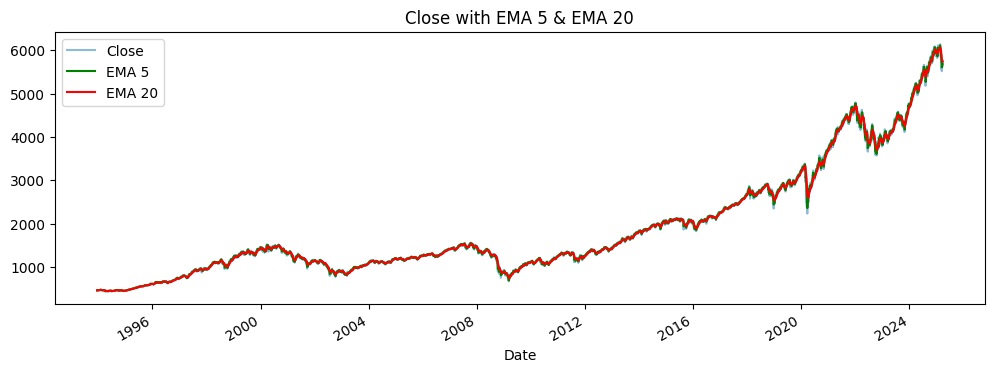

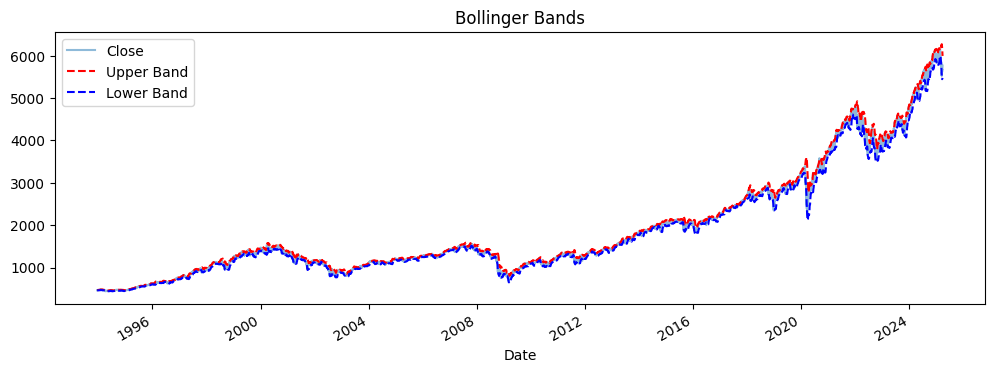

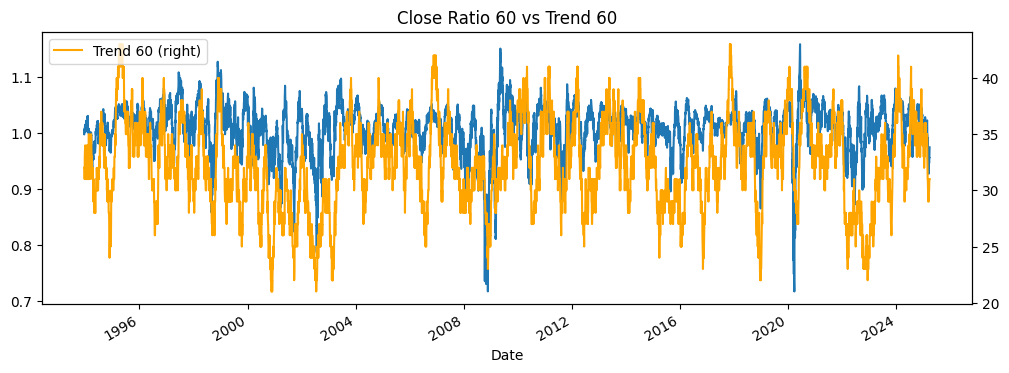

In [278]:
os.makedirs("../reports/images/features", exist_ok=True)

# RSI
plt.figure(figsize=(12, 4))
df["RSI_14"].plot(title="RSI (14)")
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.legend()
plt.savefig("../reports/images/features/RSI_14.png")
plt.show()
plt.close()

# MACD
plt.figure(figsize=(12, 4))
df["MACD"].plot(label="MACD", color="blue")
df["MACD_Signal"].plot(label="Signal", color="orange")
plt.title("MACD vs Signal")
plt.legend()
plt.savefig("../reports/images/features/MACD.png")
plt.show()
plt.close()

# EMA
plt.figure(figsize=(12, 4))
df["Close"].plot(label="Close", alpha=0.5)
df["EMA_5"].plot(label="EMA 5", color="green")
df["EMA_20"].plot(label="EMA 20", color="red")
plt.title("Close with EMA 5 & EMA 20")
plt.legend()
plt.savefig("../reports/images/features/EMA.png")
plt.show()
plt.close()

# Bollinger Bands
plt.figure(figsize=(12, 4))
df["Close"].plot(label="Close", alpha=0.5)
df["BB_High"].plot(label="Upper Band", linestyle="--", color="red")
df["BB_Low"].plot(label="Lower Band", linestyle="--", color="blue")
plt.title("Bollinger Bands")
plt.legend()
plt.savefig("../reports/images/features/BollingerBands.png")
plt.show()
plt.close()

# CloseRatio vs Trend
plt.figure(figsize=(12, 4))
df["Close_Ratio_60"].plot(label="Close Ratio 60")
df["Trend_60"].plot(label="Trend 60", secondary_y=True, color="orange")
plt.title("Close Ratio 60 vs Trend 60")
plt.legend(loc="upper left")
plt.savefig("../reports/images/features/CloseRatio_Trend_60.png")
plt.show()
plt.close()